<h1 style="text-align: center">
In the name of God
</h1>
<h1 style="text-align: center">
Deep Learning HW4
</h1>

## Imports 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/MSC1401_1/DeepLearning/HW4

/content/drive/MyDrive/MSC1401_1/DeepLearning/HW4


In [2]:
import numpy as np
import json
import re
import math

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate


## Some useful constants

In [4]:
EMB_SIZE = 300
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
TRAIN_BATCH_SIZE = 32
TEST_EVAL_BATCH_SIZE = 32
# You can define your own constant in here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load the data

This data is based on
<a href="http://www.cs.cornell.edu/people/pabo/movie-review-data/">this link</a>
and contains movie reviews sentiment-analysis.

In [5]:
with open('./dataset.json') as f:
    all_dataset = json.load(f)
    
for section in all_dataset.keys():
    l = len(all_dataset[section])
    print(f"{section} lenght is: {l}")

train lenght is: 8000
eval lenght is: 2000
test lenght is: 662


## Download and extract the embeddings

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-01-01 18:11:05--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-01 18:11:05--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2023-01-01 18:13:44 (5.19 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]



In [ ]:
!unzip ./glove.6B.zip -d "./glove/"

Archive:  ./glove.6B.zip
replace ./glove/glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./glove/glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./glove/glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./glove/glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Create embedding matrix and useful functions

In [6]:
word_list = []
emb_list = []
with open(f'./glove/glove.6B.{EMB_SIZE}d.txt','r') as f:
    for line in f.read().strip().split('\n'):
        values = line.split()
        word = values[0]
        emb = values[1:]
        word_list.append(word)
        emb_list.append(emb)
        
emb_matrix = np.array(emb_list, 'float32')

In [7]:
# We initialize <UNK> token as an average of all embedings
unk_emb = np.mean(emb_matrix, axis=0, keepdims=True)
word_list.append(UNK_TOKEN)
emb_matrix = np.vstack((emb_matrix, unk_emb))

# We initialize <PAD> token as zeroes
pad_emb = np.zeros((1, EMB_SIZE))
word_list.append(PAD_TOKEN)
emb_matrix = np.vstack((emb_matrix, pad_emb))

In [8]:
reverse_map = {word: id for (id, word) in enumerate(word_list)}

def word_to_ids(word: str) -> list:
    word = word.strip()
    if word == "":
        return []
    if word in reverse_map:
        return [reverse_map[word]]
    elif word[-3:] in ["n't", "'re"]:
        return word_to_ids(word[:-3]) + word_to_ids(word[-3:])
    elif word[-2:] in ["'s", "'d", "'m"]:
        return word_to_ids(word[:-2]) + word_to_ids(word[-2:])
    else:
        word = word.replace("'", "")
        if word in reverse_map:
            return [reverse_map[word]]
    return [reverse_map[UNK_TOKEN]]
    
def id_to_word(id: int) -> str:
    return word_list[id]

## Tokenizer and sentence useful tools

In [9]:
def tokenizer(sentence: str) -> list:
    sentence = sentence.strip()
    return re.split("[ -]+", sentence)

def sentence_to_ids(sentence: str) -> list:
    return sum(map(word_to_ids, tokenizer(sentence)), [])

def ids_to_sentence(ids: list) -> list:
    return ' '.join(map(id_to_word, ids))

# Part 1: Predict relationships among words (30% grade)

Now you will write a function that will use the word embeddings to predict relationships among words.
* The function will take as input three words.
* The first two are related to each other.
* It will predict a 4th word which is related to the third word in a similar manner as the two first words are related to each other.
* As an example, "Athens is to Greece as Bangkok is to ______"?
* You will write a program that is capable of finding the fourth word.
* We will give you a hint to show you how to compute this.

A similar analogy would be the following:

<img src = 'https://msadraeij.ir:2083/public_assets/vectors.jpg' width="width" height="height" style="width:467px;height:200px;"/>

You will implement a function that can tell you the capital of a country.
You should use the same methodology shown in the figure above. To do this,
compute you'll first compute cosine similarity metric or the Euclidean distance.

### Cosine Similarity

The cosine similarity function is:

$$\cos (\theta)=\frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\|\|\mathbf{B}\|}=\frac{\sum_{i=1}^{n} A_{i} B_{i}}{\sqrt{\sum_{i=1}^{n} A_{i}^{2}} \sqrt{\sum_{i=1}^{n} B_{i}^{2}}}\tag{1}$$

$A$ and $B$ represent the word vectors and $A_i$ or $B_i$ represent index i of that vector.
& Note that if A and B are identical, you will get $cos(\theta) = 1$.
* Otherwise, if they are the total opposite, meaning, $A= -B$, then you would get $cos(\theta) = -1$.
* If you get $cos(\theta) =0$, that means that they are orthogonal (or perpendicular).
* Numbers between 0 and 1 indicate a similarity score.
* Numbers between -1-0 indicate a dissimilarity score.

**Instructions**: Implement a function that takes in two word vectors and computes the cosine distance.

**Hint**: You can use numpy functions.

In [ ]:
def cosine_similarity(A, B):
    A = A.flatten()
    B = B.flatten()
    #____________YOUR CODE GOES HERE____________
    #REPLACE INSTANCES OF 'None' with your code
    dot = np.dot(A,B)
    norma = np.sqrt(np.dot(A,A))
    normb = np.sqrt(np.dot(B,B))
    cos = dot/(norma*normb)
    #______________END BLOCK CODE_______________
    return cos

### Euclidean distance

You will now implement a function that computes the similarity between two vectors using the Euclidean distance.
Euclidean distance is defined as:

$$ \begin{aligned} d(\mathbf{A}, \mathbf{B})=d(\mathbf{B}, \mathbf{A}) &=\sqrt{\left(A_{1}-B_{1}\right)^{2}+\left(A_{2}-B_{2}\right)^{2}+\cdots+\left(A_{n}-B_{n}\right)^{2}} \\ &=\sqrt{\sum_{i=1}^{n}\left(A_{i}-B_{i}\right)^{2}} \end{aligned}$$

* $n$ is the number of elements in the vector
* $A$ and $B$ are the corresponding word vectors. 
* The more similar the words, the more likely the Euclidean distance will be close to 0. 

**Instructions**: Write a function that computes the Euclidean distance between two vector

In [ ]:
def euclidean(A, B):
    #____________YOUR CODE GOES HERE____________
    d = np.linalg.norm(A-B)
    #______________END BLOCK CODE_______________
    return d

### Let's find out queen

We are going to find queen using `Cosine Similarity`

In [ ]:
king_emb = emb_matrix[word_to_ids('king')]
man_emb = emb_matrix[word_to_ids('man')]
woman_emb = emb_matrix[word_to_ids('woman')]

query = king_emb - man_emb + woman_emb
word_scores = list(map(lambda x: (x[0], cosine_similarity(query, x[1])), zip(word_list[:-1], emb_matrix)))
sorted_word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)
top5 = sorted_word_scores[:5]
print(top5)

[('king', 0.8065858072579271), ('queen', 0.6896163179535121), ('monarch', 0.5575490920610626), ('throne', 0.5565374575062252), ('princess', 0.5518684267067457)]


**It's Great**

Queen is in top5

### Finding the country of each capital

Now, you  will use the previous functions to compute similarities between vectors,
and use these to find the capital cities of countries. You will write a function that
takes in three words, and the embeddings dictionary. Your task is to find the
capital cities. For example, given the following words: 

- 1: Athens 2: Greece 3: Baghdad,

your task is to predict the country 4: Iraq.

**Instructions**: 

1. To predict the capital you might want to look at the *King - Man + Woman = Queen* example above, and implement that scheme into a mathematical function, using the word embeddings and a similarity function.

2. Iterate over the embeddings dictionary and compute the cosine similarity score between your vector and the current word embedding.

3. You should add a check to make sure that the word you return is not any of the words that you fed into your function. Return the one with the highest score.

In [ ]:
def get_top5_country(city1, country1, city2):
    #____________YOUR CODE GOES HERE____________

    group = set((city1, country1, city2))

    city1_emb =  emb_matrix[word_to_ids(city1)]
    country1_emb = emb_matrix[word_to_ids(country1)]
    city2_emb = emb_matrix[word_to_ids(city2)]

    query = country1_emb - city1_emb + city2_emb

    word_scores = list(filter(lambda x: x[0] not in group,map(lambda x: (x[0], cosine_similarity(query, x[1])), zip(word_list[:-1], emb_matrix))))
    sorted_word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)
    top5 = sorted_word_scores[:5]
   
    #______________END BLOCK CODE_______________
    return top5

In [ ]:
get_top5_country('athens', 'greece', 'tehran')

[('iran', 0.7953298646285731),
 ('iranian', 0.6305805062022181),
 ('syria', 0.5452216125676077),
 ('ahmadinejad', 0.5421629020046366),
 ('iranians', 0.5278357585912685)]

**It's Great**

Iran is in top5

# Part 2: Plotting the vectors using PCA(20% grade)

Now you will explore the distance between word vectors after reducing their dimension.
The technique we will employ is known as
[*principal component analysis* (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).
As we saw, we are working in a 300-dimensional space in this case.
Although from a computational perspective we were able to perform a good job,
it is impossible to visualize results in such high dimensional spaces.

You can think of PCA as a method that projects our vectors in a space of reduced
dimension, while keeping the maximum information about the original vectors in
their reduced counterparts. In this case, by *maximum infomation* we mean that the
Euclidean distance between the original vectors and their projected siblings is
minimal. Hence vectors that were originally close in the embeddings dictionary,
will produce lower dimensional vectors that are still close to each other.

You will see that when you map out the words, similar words will be clustered
next to each other. For example, the words 'sad', 'happy', 'joyful' all describe
emotion and are supposed to be near each other when plotted.
The words: 'oil', 'gas', and 'petroleum' all describe natural resources.
Words like 'city', 'village', 'town' could be seen as synonyms and describe a
similar thing.

Before plotting the words, you need to first be able to reduce each word vector
with PCA into 2 dimensions and then plot it. The steps to compute PCA are as follows:

1. Mean normalize the data
2. Compute the covariance matrix of your data ($\Sigma$). 
3. Compute the eigenvectors and the eigenvalues of your covariance matrix
4. Multiply the first K eigenvectors by your normalized data. The transformation should look something as follows:

<img src = 'https://msadraeij.ir:2083/public_assets/word_embf.jpg' width="width" height="height" style="width:800px;height:200px;"/>

**Instructions**: 

You will write a program that takes in a data set where each row corresponds to a word vector. 
* The word vectors are of dimension 300. 
* Use PCA to change the 300 dimensions to `n_components` dimensions. 
* The new matrix should be of dimension `m, n_componentns`. 

* First de-mean the data
* Get the eigenvalues using `linalg.eigh`.  Use `eigh` rather than `eig` since R is symmetric.  The performance gain when using `eigh` instead of `eig` is substantial.
* Sort the eigenvectors and eigenvalues by decreasing order of the eigenvalues.
* Get a subset of the eigenvectors (choose how many principle components you want to use using `n_components`).
* Return the new transformation of the data by multiplying the eigenvectors with the original data.

In [ ]:
def compute_pca(X, n_components=2):

    #____________YOUR CODE GOES HERE____________

    X_demeaned = X - np.mean(X, axis=0)
    covariance_matrix = np.cov(X_demeaned,rowvar = False)
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix)
    idx_sorted = np.argsort(eigen_vals)
    idx_sorted_decreasing = idx_sorted[::-1]
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]
    eigen_vecs_subset = eigen_vecs_sorted[:,:n_components]
    X_reduced = np.dot(eigen_vecs_subset.T,X_demeaned.T).T
    #______________END BLOCK CODE_______________

    return X_reduced

### Plot some words

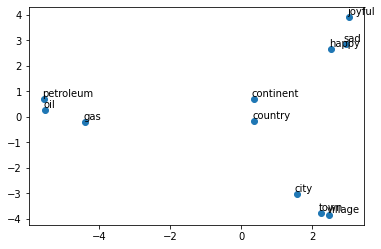

In [ ]:
selected_words = ['oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']

selected_words_emb = np.vstack([emb_matrix[word_to_ids(word)] for word in selected_words])

result = compute_pca(selected_words_emb, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(selected_words):
    plt.annotate(word, xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))
plt.show()

# Part 3: Classification using a simple bag of words (10% grade)

In [ ]:
def sentence_to_emb(sentence: str):
    return_value = np.zeros((EMB_SIZE,))
    token_ids = sentence_to_ids(sentence)
    #____________YOUR CODE GOES HERE____________
    return_value = np.mean([emb_matrix[id] for id in token_ids], axis = 0)
    #______________END BLOCK CODE_______________
    return return_value

### Define our simple model

In [ ]:
model = nn.Sequential(
    nn.Linear(EMB_SIZE, EMB_SIZE),
    nn.ReLU(),
    nn.Linear(EMB_SIZE, EMB_SIZE),
    nn.ReLU(),
    nn.Linear(EMB_SIZE, EMB_SIZE),
    nn.ReLU(),
    nn.Linear(EMB_SIZE, EMB_SIZE),
    nn.ReLU(),
    nn.Linear(EMB_SIZE, 2)
)

### Define our dataset and dataloader

In [ ]:
class Method1Dataset(Dataset):
    def __init__(self, datadict):
        self.data = [(sentence_to_emb(sentence), semantic)for sentence, semantic in datadict]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
train_dataset = Method1Dataset(all_dataset['train'])
eval_dataset = Method1Dataset(all_dataset['eval'])
test_dataset = Method1Dataset(all_dataset['test'])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=TEST_EVAL_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_EVAL_BATCH_SIZE, shuffle=True)

### Define our training routine

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        x, trg = batch
        optimizer.zero_grad()
        output = model(x.float())
        
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            x, trg = batch
            output = model(x.float())

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### Train the model

In [ ]:
for epoch in range(10):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    valid_loss = evaluate(model, eval_dataloader, criterion)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01
	Train Loss: 0.606
	 Val. Loss: 0.600
Epoch: 02
	Train Loss: 0.522
	 Val. Loss: 0.520
Epoch: 03
	Train Loss: 0.488
	 Val. Loss: 0.489
Epoch: 04
	Train Loss: 0.467
	 Val. Loss: 0.577
Epoch: 05
	Train Loss: 0.450
	 Val. Loss: 0.505
Epoch: 06
	Train Loss: 0.431
	 Val. Loss: 0.501
Epoch: 07
	Train Loss: 0.407
	 Val. Loss: 0.512
Epoch: 08
	Train Loss: 0.382
	 Val. Loss: 0.522
Epoch: 09
	Train Loss: 0.346
	 Val. Loss: 0.539
Epoch: 10
	Train Loss: 0.324
	 Val. Loss: 0.593


### Check the results

In [ ]:
def get_all_targets_and_predicted(model, iterator):
    all_trg = []
    all_prd = []
    with torch.no_grad():
        for batch in iterator:
            x, trg = batch
            output = model(x.float())
            prd = output.argmax(1).tolist()
            
            all_trg += trg
            all_prd += prd
    return all_trg, all_prd

In [ ]:
print('__________________TRAIN DATASET__________________')
trg, prd = get_all_targets_and_predicted(model, train_dataloader)
print(classification_report(trg, prd))
print('__________________EVAL DATASET__________________')
trg, prd = get_all_targets_and_predicted(model, eval_dataloader)
print(classification_report(trg, prd))
print('__________________TEST DATASET__________________')
trg, prd = get_all_targets_and_predicted(model, test_dataloader)
print(classification_report(trg, prd))

__________________TRAIN DATASET__________________
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      4000
           1       0.89      0.92      0.90      4000

    accuracy                           0.90      8000
   macro avg       0.90      0.90      0.90      8000
weighted avg       0.90      0.90      0.90      8000

__________________EVAL DATASET__________________
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1000
           1       0.73      0.77      0.75      1000

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000

__________________TEST DATASET__________________
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       331
           1       0.75      0.77      0.76       331

    accuracy                      

# Part 4: Classification using an LSTM classifier (40% grade)

Use pytorch to implement an lstm model classifier. You can use any hyperparameters you want. You must report `classification_report` like previous example for all datasets. Remember your embeding layer initial value must be `emb_matrix`.

You must train the model two times.
First time freeze the embeding layer and second time fine-tune it end2end.
After that compare these two results and explatin the trade-off between freezing or fine-tuning the embedding layer.
You can read more about this in <a href="https://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture04-backprop.pdf">this link</a>.

Good Luck

In [10]:
#To be able to use more ram :)
del word_list, emb_list

In [11]:
class Method2Dataset(Dataset):
    def __init__(self, datadict):
        self.data = []
        self.labels = []
        for sentence, semantic in datadict:
            self.data.append(sentence)
            self.labels.append(semantic)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx],self.labels[idx]

In [12]:
train_dataset = Method2Dataset(all_dataset['train'])
eval_dataset = Method2Dataset(all_dataset['eval'])
test_dataset = Method2Dataset(all_dataset['test'])

In [13]:
# For this part I used methods of the following link for converting sentences to tensor as lstm input
# https://www.kaggle.com/code/fyycssx/first-try-lstm-with-glove-by-pytorch
def sentences_to_tensors(sentences, word_to_ids, max_len = 64, pad_token = 0):
    # Returns a tensor of padded indexes of word ids in a sentence
    word_ids_list = [sentence_to_ids(sent) for sent in sentences]
    max_len = min(max_len,max([len(indexes) for indexes in word_ids_list]))
    truncated_indexes = [indexes[:max_len] for indexes in word_ids_list]
    padded_indexes = [indexes+[0]*(max_len - len(indexes)) for indexes in truncated_indexes]
    return torch.LongTensor(padded_indexes)

def train_collate(batch):
    data,labels = zip(*batch)
    input_tensor = sentences_to_tensors(data,word_to_ids)
    return input_tensor,torch.LongTensor(labels)


train_loader = DataLoader(train_dataset,batch_size= TRAIN_BATCH_SIZE, shuffle = True,collate_fn=train_collate,drop_last = True)
val_loader = DataLoader(eval_dataset,batch_size=TEST_EVAL_BATCH_SIZE,shuffle=False,collate_fn=train_collate,drop_last = True)
test_loader = DataLoader(test_dataset,batch_size=TEST_EVAL_BATCH_SIZE,shuffle=False,collate_fn=train_collate,drop_last = True)


In [23]:
for data, labels in train_loader:
      print(data)
      print(data.shape)
      print(labels.shape)
      break

tensor([[  1402,   3244,      4,  ...,      0,      0,      0],
        [    12,   4694,     54,  ...,      0,      0,      0],
        [  4022,      1,      7,  ...,      0,      0,      0],
        ...,
        [  4779,      0,    870,  ...,      0,      0,      0],
        [   575, 113113,     29,  ...,      0,      0,      0],
        [  7014,   4943,    118,  ..., 106593,      2,      0]])
torch.Size([32, 39])
torch.Size([32])


In [19]:
class SentimentLSTM(nn.Module):
    def __init__(self, output_size, hidden_dim, n_layers,emb_matrix, freeze, drop_prob=0.5 ):
        super().__init__()

        self.embedding_dim = emb_matrix.shape[1]
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding.from_pretrained(embeddings=torch.Tensor(emb_matrix).to(device), freeze = freeze)
        self.lstm = nn.LSTM(self.embedding_dim, hidden_dim, n_layers, bidirectional = True,
                            dropout=drop_prob, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim*2, output_size)

        

    def forward(self, x):
        x = self.embedding(x)
        x,(hs,cs) = self.lstm(x)
        x = self.fc(x[:,-1,:])
        return  x
    


In [71]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        x, trg = batch
        x = x.cuda()
        trg = trg.cuda()
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            x, trg = batch
            x = x.cuda()
            trg = trg.cuda()
            output = model(x)

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)
def get_all_targets_and_predicted(model, iterator):
    all_trg = []
    all_prd = []
    with torch.no_grad():
        for batch in iterator:
            x, trg = batch
            x = x.cuda()
            trg = trg.cuda()
            output = model(x)
            prd = output.cpu().numpy().argmax(1).tolist()
            
            all_trg += trg.cpu().numpy().tolist()
            all_prd += prd
    return all_trg, all_prd

#Freezing Embedding

In [45]:
no_layers = 2
output_dim = 2
hidden_dim = 128


model_freeze = SentimentLSTM(output_dim, hidden_dim, no_layers,emb_matrix,True,drop_prob=0.5)
model_freeze.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_freeze.parameters(), lr=0.001)

In [46]:
for epoch in range(10):
    train_loss = train(model_freeze, train_loader, optimizer, criterion)
    valid_loss = evaluate(model_freeze, val_loader, criterion)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01
	Train Loss: 0.695
	 Val. Loss: 0.693
Epoch: 02
	Train Loss: 0.693
	 Val. Loss: 0.693
Epoch: 03
	Train Loss: 0.693
	 Val. Loss: 0.694
Epoch: 04
	Train Loss: 0.693
	 Val. Loss: 0.693
Epoch: 05
	Train Loss: 0.672
	 Val. Loss: 0.572
Epoch: 06
	Train Loss: 0.531
	 Val. Loss: 0.494
Epoch: 07
	Train Loss: 0.466
	 Val. Loss: 0.488
Epoch: 08
	Train Loss: 0.412
	 Val. Loss: 0.462
Epoch: 09
	Train Loss: 0.362
	 Val. Loss: 0.472
Epoch: 10
	Train Loss: 0.315
	 Val. Loss: 0.517


In [72]:
print('__________________TRAIN DATASET__________________')
trg, prd = get_all_targets_and_predicted(model_freeze, train_loader)
print(classification_report(trg, prd))
print('__________________EVAL DATASET__________________')
trg, prd = get_all_targets_and_predicted(model_freeze, val_loader)
print(classification_report(trg, prd))
print('__________________TEST DATASET__________________')
trg, prd = get_all_targets_and_predicted(model_freeze, test_loader)
print(classification_report(trg, prd))

__________________TRAIN DATASET__________________
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4000
           1       0.94      0.87      0.90      4000

    accuracy                           0.91      8000
   macro avg       0.91      0.91      0.91      8000
weighted avg       0.91      0.91      0.91      8000

__________________EVAL DATASET__________________
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       990
           1       0.81      0.73      0.77       994

    accuracy                           0.78      1984
   macro avg       0.79      0.78      0.78      1984
weighted avg       0.79      0.78      0.78      1984

__________________TEST DATASET__________________
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       323
           1       0.86      0.73      0.79       317

    accuracy                      

#Finetuning Embedding

In [73]:
no_layers = 2
output_dim = 2
hidden_dim = 256


model = SentimentLSTM(output_dim, hidden_dim, no_layers,emb_matrix,False,drop_prob=0.5)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [74]:
for epoch in range(10):
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, val_loader, criterion)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01
	Train Loss: 0.694
	 Val. Loss: 0.694
Epoch: 02
	Train Loss: 0.694
	 Val. Loss: 0.693
Epoch: 03
	Train Loss: 0.693
	 Val. Loss: 0.693
Epoch: 04
	Train Loss: 0.686
	 Val. Loss: 0.618
Epoch: 05
	Train Loss: 0.484
	 Val. Loss: 0.444
Epoch: 06
	Train Loss: 0.224
	 Val. Loss: 0.600
Epoch: 07
	Train Loss: 0.102
	 Val. Loss: 0.724
Epoch: 08
	Train Loss: 0.052
	 Val. Loss: 0.831
Epoch: 09
	Train Loss: 0.027
	 Val. Loss: 1.096
Epoch: 10
	Train Loss: 0.014
	 Val. Loss: 1.077


In [75]:
print('__________________TRAIN DATASET__________________')
trg, prd = get_all_targets_and_predicted(model, train_loader)
print(classification_report(trg, prd))
print('__________________EVAL DATASET__________________')
trg, prd = get_all_targets_and_predicted(model, val_loader)
print(classification_report(trg, prd))
print('__________________TEST DATASET__________________')
trg, prd = get_all_targets_and_predicted(model, test_loader)
print(classification_report(trg, prd))

__________________TRAIN DATASET__________________
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4000
           1       1.00      1.00      1.00      4000

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

__________________EVAL DATASET__________________
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       990
           1       0.77      0.79      0.78       994

    accuracy                           0.77      1984
   macro avg       0.77      0.77      0.77      1984
weighted avg       0.77      0.77      0.77      1984

__________________TEST DATASET__________________
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       323
           1       0.78      0.79      0.78       317

    accuracy                      

Analysis:
The embedding matrix which used in the initialization of the Embedding layer is highly trained on a large corpus of text. The training and the data are so huge that the embedding has learnt a type of association between words.
We can enjoy the benefits of such an embedding by keeping it untrainable. As it is obvious from results, additional training in the context of our task, may result in unusual behaviour of the Embedding layer and also distort the learned associations. Also the model may overfit the data.